In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


from sklearn.metrics import mean_squared_error

from datetime import date, timedelta
from typing import Callable, Tuple

foot_traffic = pd.read_csv('data/foot_traffic.csv')
foot_traffic.columns = ['traffic']

inital_date = date(2000, 1, 1)
one_week_delta = timedelta(weeks=1)

weekly_dates = []
for i in range(len(foot_traffic)):
    weekly_dates.append((i * one_week_delta) + inital_date)
    

foot_traffic['date'] = pd.to_datetime(weekly_dates)
foot_traffic.set_index('date', inplace=True)
foot_traffic.index.freq = 'W-SAT'
foot_traffic.head()

traffic
date                  
2000-01-01  500.496714
2000-01-08  500.522366
2000-01-15  501.426876
2000-01-22  503.295990
2000-01-29  504.132695

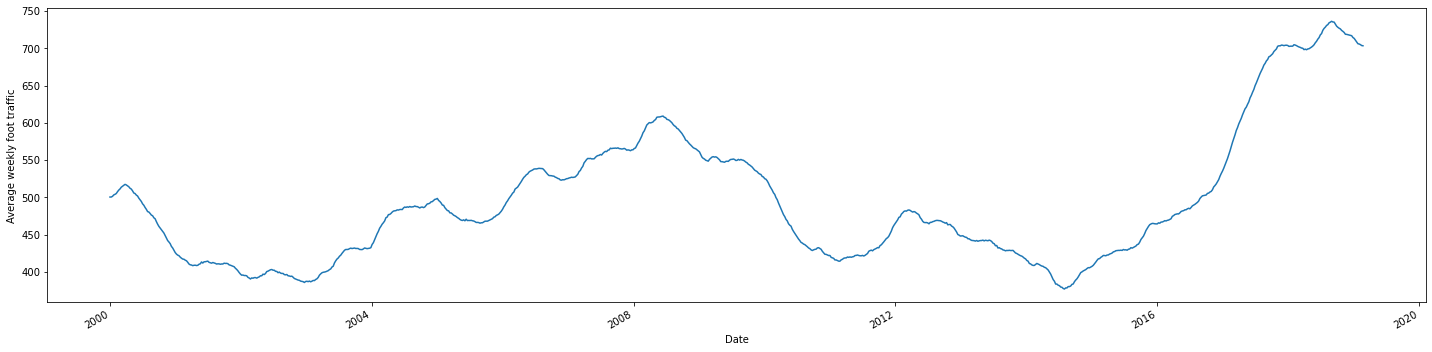

In [2]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(foot_traffic['traffic'])
ax.set_xlabel('Date')
ax.set_ylabel('Average weekly foot traffic')

fig.autofmt_xdate()
plt.tight_layout()

plt.show();

### Stationarity test

In [3]:
adf_test = adfuller(foot_traffic['traffic'])
print('Stationary' if adf_test[1] < 0.05 else 'Non-stationary')

Non-stationary


#### Apply transformation and test stationarity again

In [4]:
foot_traffic['logged_traffic'] = np.log(foot_traffic.traffic)
adf_test = adfuller(foot_traffic['logged_traffic'])
print('Stationary' if adf_test[1] < 0.05 else 'Non-stationary')

Non-stationary


In [5]:
foot_traffic['traffic_diff'] = foot_traffic.traffic.diff()
adf_test = adfuller(foot_traffic['traffic_diff'][1:])
print('Stationary' if adf_test[1] < 0.05 else 'Non-stationary')

Stationary


In [6]:
foot_traffic['logged_traffic_diff'] = foot_traffic.logged_traffic.diff()
adf_test = adfuller(foot_traffic['logged_traffic_diff'][1:])
print('Stationary' if adf_test[1] < 0.05 else 'Non-stationary')

Stationary


In [7]:
data = foot_traffic.dropna()
data.head()

traffic  logged_traffic  traffic_diff  logged_traffic_diff
date                                                                     
2000-01-08  500.522366        6.215652      0.025651             0.000051
2000-01-15  501.426876        6.217458      0.904511             0.001806
2000-01-22  503.295990        6.221178      1.869114             0.003721
2000-01-29  504.132695        6.222840      0.836705             0.001661
2000-02-05  505.172544        6.224900      1.039848             0.002061

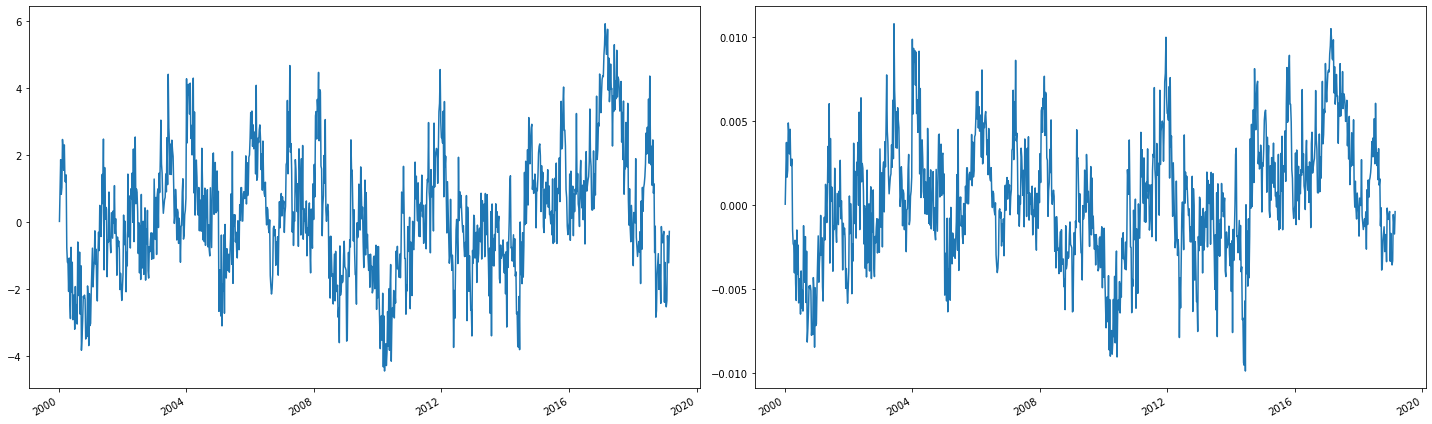

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

axs[0].plot(data.traffic_diff)
axs[1].plot(data.logged_traffic_diff)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

### Plot ACF

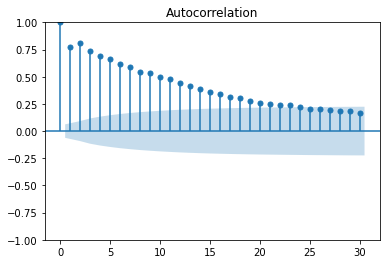

In [9]:
plot_acf(data.traffic_diff);

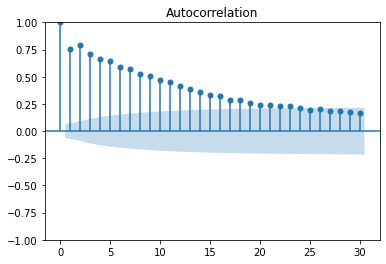

In [10]:
plot_acf(data.logged_traffic_diff);

### Polt PACF

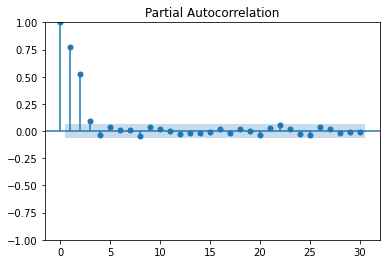

In [11]:
plot_pacf(data.traffic_diff, method='ywm');

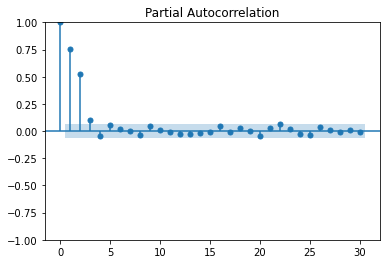

In [12]:
plot_pacf(data.logged_traffic_diff, method='ywm');

### Create train and test sets

In [13]:
test_horizon = 52
train = data[:-test_horizon]
test = data[-test_horizon:]

### Train model and perform rolling forecast

In [29]:
def rolling_forecast(ser: pd.Series, train_len: int, horizon: int, window: int, method: str='mean', fitting_func: Callable = None, arma_order: Tuple[int, int, int] = None) -> list:
    total_len = train_len + horizon
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(ser[:i])
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = ser[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'ARMA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            forecasts = fitting_func(ser[:i], i, arma_order, window)
            pred_MA.extend(forecasts)
        return pred_MA


def sarimax_func(arr: pd.Series, i: int, order: Tuple[int, int, int], window: int) -> list:
    model = SARIMAX(arr, order=order)
    res = model.fit(disp=False)
    predictions = res.get_prediction(0, i + window - 1)
    oos_pred = predictions.predicted_mean[-window:]
    return oos_pred

In [33]:
test.loc[:, 'predicted_ar'] = rolling_forecast(data['traffic_diff'], len(train), len(test), 1, 'ARMA', sarimax_func, (3, 0, 0))

/var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/ipykernel_84834/2197350847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'predicted_ar'] = rolling_forecast(data['traffic_diff'], len(train), len(test), 1, 'ARMA', sarimax_func, (3, 0, 0))


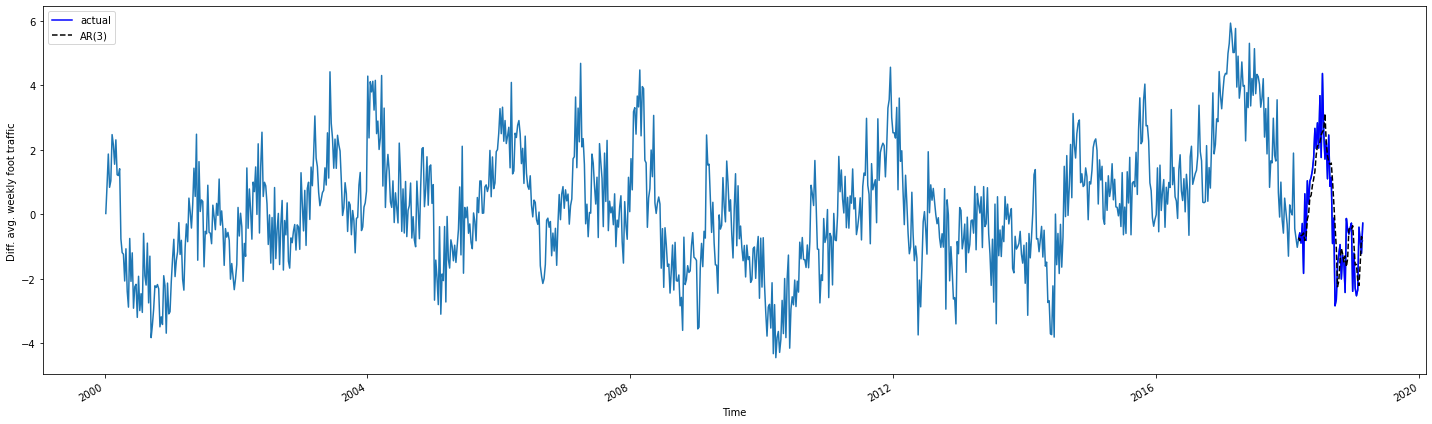

In [42]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(data['traffic_diff'])
ax.plot(test['traffic_diff'], 'b-', label='actual')
ax.plot(test['predicted_ar'], 'k--', label='AR(3)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

In [43]:
mse_AR = mean_squared_error(test['traffic_diff'], test['predicted_ar'])
print(mse_AR)

0.924247916293692


In [140]:
pickup_index = data.index[len(data)-len(test)]
data.loc[:, 'pred_traffic'] = pd.Series(dtype='float32')
data.loc[pickup_index:, 'pred_traffic'] = data.loc[pickup_point, 'traffic'] + test['predicted_ar'].cumsum()

/var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/ipykernel_84834/1592211612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'pred_traffic'] = pd.Series(dtype='float32')


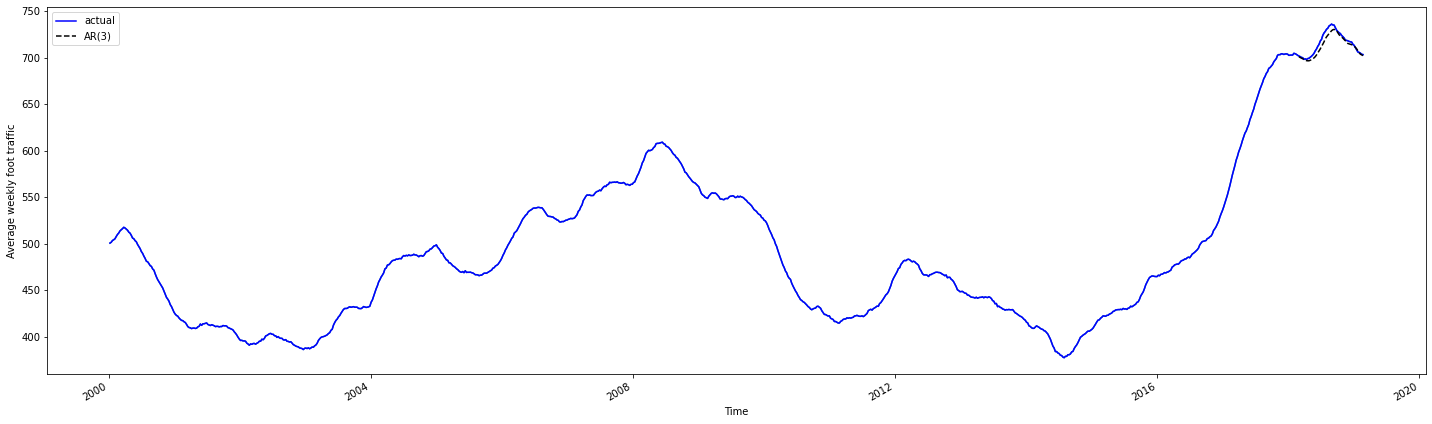

In [141]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(data['traffic'])
ax.plot(data['traffic'], 'b-', label='actual')
ax.plot(data['pred_traffic'], 'k--', label='AR(3)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

fig.autofmt_xdate()
plt.tight_layout()

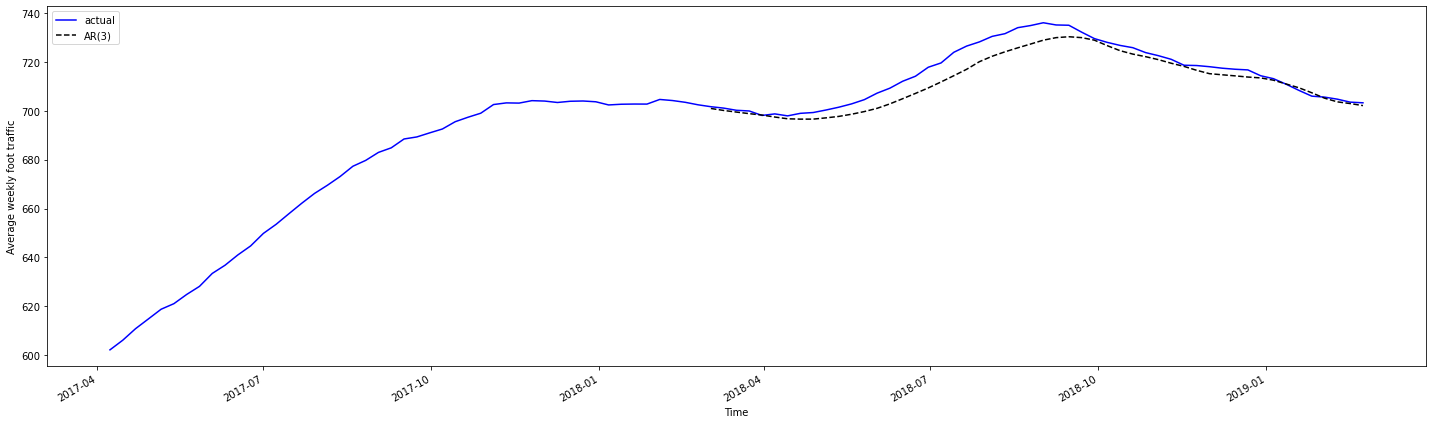

In [142]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(data['traffic'][900:], 'b-', label='actual')
ax.plot(data['pred_traffic'][900:], 'k--', label='AR(3)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

fig.autofmt_xdate()
plt.tight_layout()

In [148]:
msqe = mean_squared_error(data.traffic[pickup_index:], data.pred_traffic[pickup_index:])
print(msqe, np.sqrt(msqe))

20.438803476071016 4.520929492490567


In [144]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(data.traffic[pickup_index:], data.pred_traffic[pickup_index:])

3.478032293231431